In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
# %cd '/content/drive/My Drive/MindEye'
# os.chdir('/content/drive/My Drive/MindEye')

In [3]:
# !pip install git+https://github.com/openai/CLIP.git

In [4]:
import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor, GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import pandas as pd
import csv
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import requests
from model import Voxel2Blip
from torchvision import transforms
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import BlipImageProcessor
from diffusers.models import AutoencoderKL
from utils import load_image, save_image, encode_img, decode_img, to_PIL
from transformers.image_utils import OPENAI_CLIP_MEAN,OPENAI_CLIP_STD

c:\Users\SWC\Desktop\Code\Machine-Learning-Final\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dataset_path = '2023-Machine-Learning-Dataset/'
training_path = dataset_path + 'subj0{}/training_split/'
training_fmri_path = training_path + 'training_fmri/'
training_images_path = training_path + 'training_images/'
testing_path = dataset_path + 'subj0{}/test_split/test_fmri/'
image_infos_path = dataset_path + 'image_infos/subj0{}_infos_train.csv'

In [6]:
class MyDataset(Dataset):
  def __init__(self, fmri_data,images_folder, images_data, transform=None ,device="cpu"):
    self.fmri_data = torch.from_numpy(fmri_data)
    self.images_data = images_data
    self.images_folder = images_folder
    self.image_paths = []
    for i in range(5000):
      self.image_paths.append(f"{images_folder}/{i}.png")
    self.transform = transform

  def __len__(self):
    return len(self.fmri_data)

  def __getitem__(self, idx):
    fmri = self.fmri_data[idx]
    image = self.images_data[idx]
    image_path = self.image_paths[idx]
    image_real = load_image(image_path)

    if(self.transform):
      image_real = self.transform(image_real)

    return fmri, image, image_real
transform = transforms.Resize([512, 512])

# Load dataset, now only subj01
lh = np.load(training_path.format(1) + 'training_fmri/lh_training_fmri.npy')
rh = np.load(training_path.format(1) + 'training_fmri/rh_training_fmri.npy')
lrh = np.concatenate((lh, rh), axis=1)

images_bilp = torch.load('subj01_image_blip_encoded.pt')['images']

my_dataset = MyDataset(lrh,training_images_path.format(1), images_bilp, transform=transform)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
modelGeneration = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", torch_dtype=torch.float16).to(device)
imgProcessor = BlipImageProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)

In [9]:
generator = torch.Generator().manual_seed(42)
trainset, validset = random_split(my_dataset, [0.9, 0.1], generator=generator)
# build dataloader
train_dataloader = DataLoader(trainset, batch_size=16, shuffle=False, num_workers=0)
val_dataloader = DataLoader(validset, batch_size=16, shuffle=False, num_workers=0)

In [10]:
model = Voxel2Blip().to(device)
checkpoint = torch.load('./ModelsBlip/550.3_f1')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
del checkpoint

FileNotFoundError: [Errno 2] No such file or directory: './ModelsBlip/550.3_f1'

In [ ]:
for train_i, data in enumerate(val_dataloader):
    voxels, images, originImages = data
    voxels = voxels.to(device).float()
    images = images.to(device).float()
    originImages = originImages.to(device).float()
    out_encoded = model(voxels)
    break

c:\Users\SWC\Desktop\Code\Machine-Learning-Final\.venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


c:\Users\SWC\Desktop\Code\Machine-Learning-Final\.venv\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


there is a man sitting on a couch with a remote control


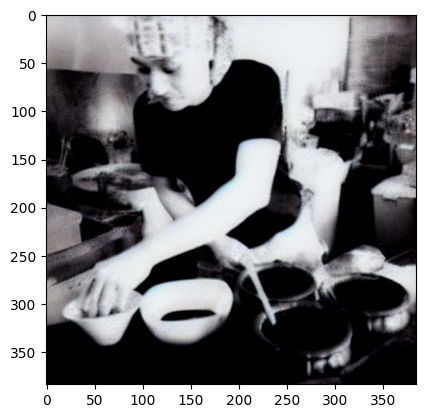

there is a blurry image of a blue light in the sky


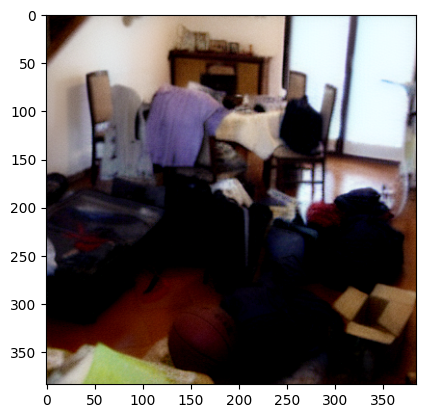

there is a picture of a bird flying in the sky


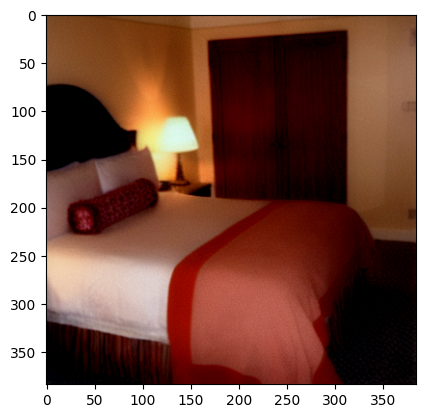

there is a picture of a blurry picture of a person on a surfboard


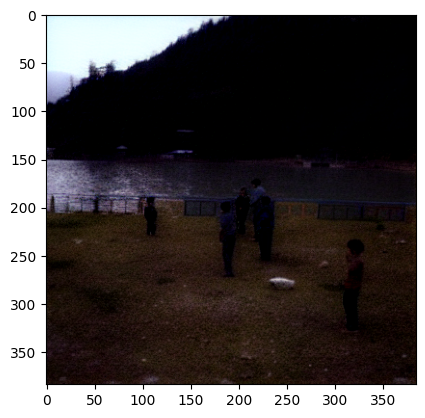

there is a blue frisbee in the sand on the beach


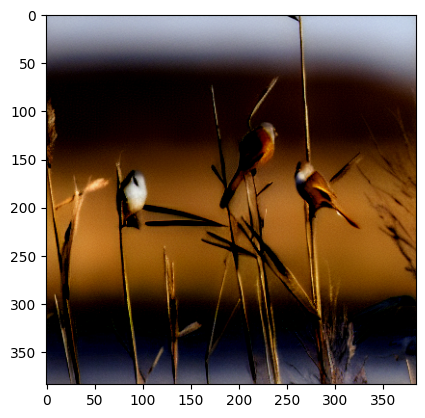

there is a picture of a man that is flying a kite


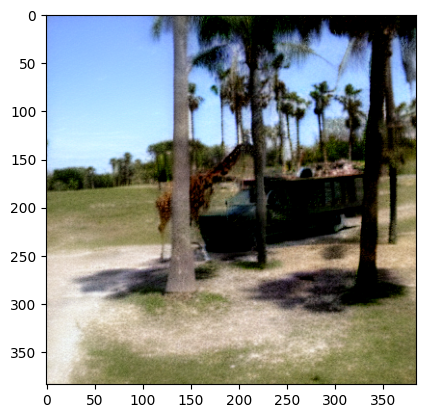

there is a blue light that is shining in the sky


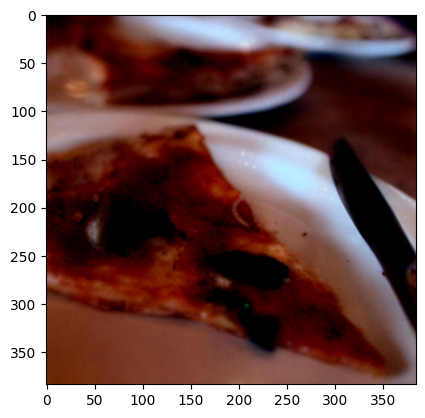

there is a blurry image of a bird flying in the sky


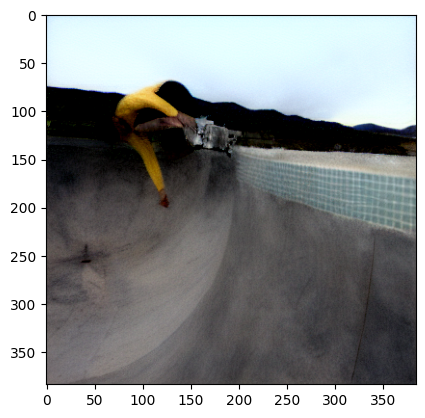

there is a plane flying through the air with a blue light


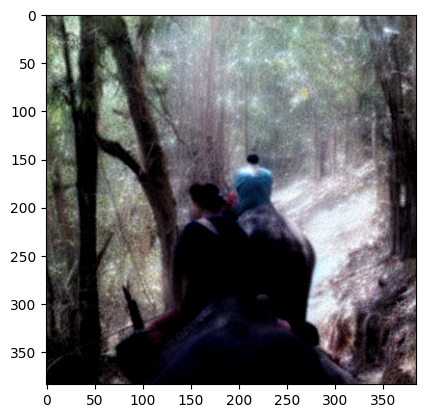

there is a picture of a blue bird flying in the sky


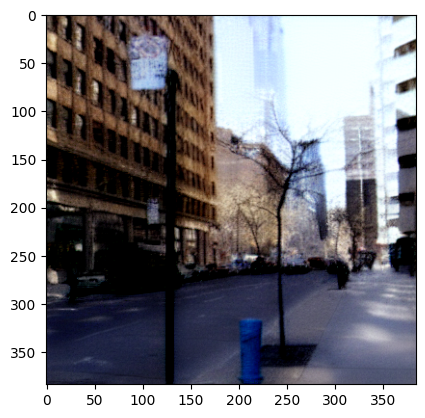

there is a picture of a fire hydrant in the middle of a field


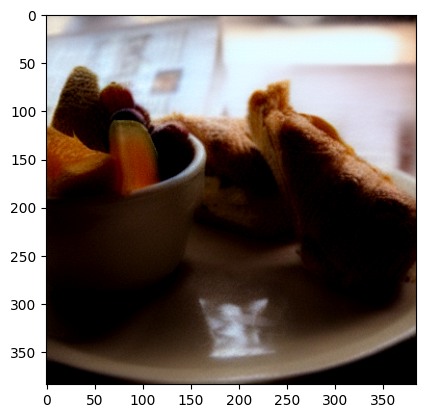

there is a picture of a blurry picture of a person on a surfboard


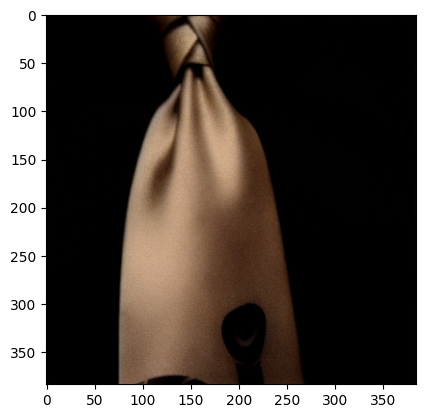

there is a picture of a picture of a dog in the rain


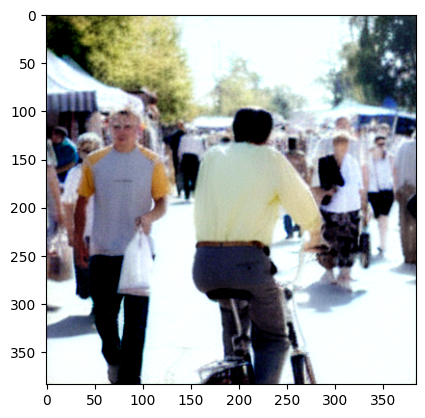

there is a picture of a blurry picture of a person on a surfboard


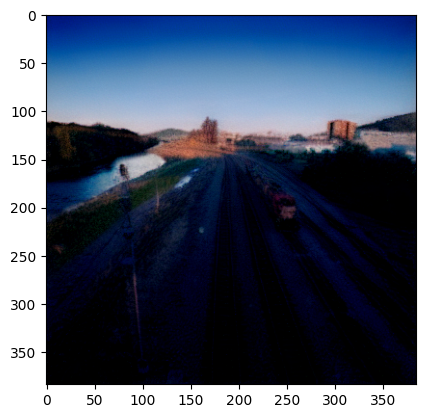

there is a picture of a bird flying in the sky


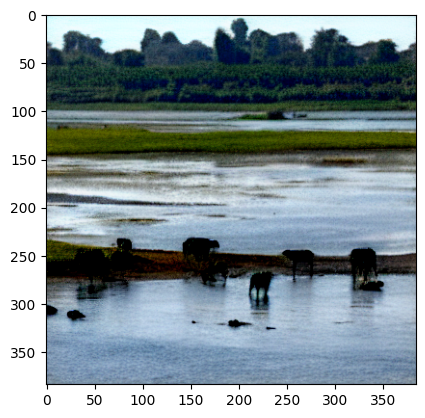

there is a picture of a blurry picture of a person on a surfboard


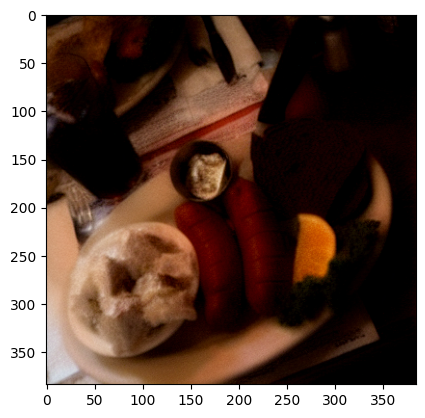

In [ ]:
for image, encoded, originImage in zip(images,out_encoded,originImages):
    imgOrigin = decode_img(image.unsqueeze(0), vae)
    img = decode_img(encoded.unsqueeze(0), vae)
    # print(imgProcessor(img,do_normalize = False)['pixel_values'][0])
    # break
    
    # encodedNormalized = imgProcessor(img,do_normalize = False)['pixel_values'][0]
    # encodedNormalized = imgProcessor.normalize(decode_img(encoded.unsqueeze(0), vae).cpu().numpy(),mean = OPENAI_CLIP_MEAN,std = OPENAI_CLIP_STD)
    # out = modelGeneration.generate(torch.from_numpy(encodedNormalized).to(device))
    out = modelGeneration.generate(img).to(device)
    print(processor.decode(out[0], skip_special_tokens=True))
    imgOrigin = ((np.transpose(imgOrigin[0].cpu().numpy(), (1, 2, 0))) * 255).astype(np.uint8)
    plt.imshow(imgOrigin)
    plt.show()
    

In [ ]:


img = load_image("./outputImg/origin_1.png")
print(img.shape)
# encoded = encode_img(img.to(device), vae.to(device))
img = (img*255).int()
inputs = processor(img.squeeze(0), return_tensors="pt").to(device, torch.float16)

out = modelGeneration.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

torch.Size([1, 3, 512, 512])


c:\Users\SWC\Desktop\Code\Machine-Learning-Final\.venv\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


there is a pizza cooking in a brick oven with flames


In [ ]:
image = imgProcessor(img,do_normalize = False)['pixel_values'][0]

In [ ]:

encoded.shape

torch.Size([1, 4, 48, 48])

In [ ]:
decode_img(encoded, vae)[0].shape

torch.Size([3, 384, 384])

In [ ]:
out = model.generate(decode_img(encoded, vae))
print(processor.decode(out[0], skip_special_tokens=True))

there is a pizza in the oven with a lot of toppings


c:\Users\SWC\Desktop\Code\Machine-Learning-Final\.venv\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
